In [2]:
import sys
sys.path.append('/home/yungdankblast/DelayedOptimization/delay-optimizer')
from FuncOptHandler import Handler
import numpy as np
from Optimizer_Scripts.DelayTypeGenerators import Undelayed, Uniform, Stochastic, Partial

## Near Minimum Trials

### Class object source

In [3]:
from Optimizer_Scripts.Delayer import Delayer
import time
import warnings

class CustomDelayer(Delayer):
    def __init__(self, delay_type, loss_func, optimizer, save_state=False, 
                 save_loss=False, save_grad=False, save_m=True, save_v=True,):
        super().__init__(delay_type, loss_func, optimizer, save_state, 
                         save_loss, save_grad)
        self.save_m = save_m
        self.save_v = save_v

    def initialize(self, x_init):
        super().initialize(x_init)
        if self.save_m: self.m_list = [self.optimizer.m_t]
        if self.save_v: self.v_list = [self.optimizer.v_t]

    def set_m(self, m):
        self.optimizer.m_t += m

    def set_v(self, v):
        self.optimizer.v_t += v

    def get_stability_params(self):
        warnings.warn("**Note that the stability parameters are only implemented properly for constant learning rates**")
        alpha_eps = next(self.optimizer.params['learning_rate']) / np.sqrt(self.optimizer.epsilon)
        beta_1 = self.optimizer.params['beta_1']
        return alpha_eps*(1-beta_1), alpha_eps*beta_1, 1-beta_1, beta_1

    def log(self, state, grad, loss):
        super().log(state, grad, loss)
        if self.save_m: self.m_list.append(self.optimizer.m_t)
        if self.save_v: self.v_list.append(self.optimizer.v_t)

    def optimize(self, x_init, maxiter=2000, tol=1e-5, break_opt=True, set_m=0, set_v=0):
        """Computes the time series using the passed optimizer from __init__, 
        saves convergence and time_series which is an array of the states
           
        Parameters - 
            x_init (ndarray, (n,)): the initial state of the calculation
            maxiter (int): the max number of iterations
            tol (float): the tolerance of convergence
            break_opt (bool): a boolean determining whether to end optimization
                after convergence 
        Returns - 
            (ndarray, (n,)): the final state of the optimization
            (bool): convergence boolean
            (float): the total optimization time in seconds
        """  
        
        class Result:
            """A Result object containing optimization data returned by the 
            Delayer class.
            """
            def __init__(self, delayer, converged, runtime):
                """Save requested values"""
                if delayer.save_state is not False:  
                    self.state_vals = np.asarray(delayer.state_list)
                    if delayer.save_state is not True:  # Extract state dimensions
                        self.state_vals = self.state_vals[:,delayer.save_state]
                        
                if delayer.save_loss is True:
                    self.loss_vals = np.asarray(delayer.loss_list)
                if delayer.save_grad is True:
                    self.grad_vals = np.asarray(delayer.grad_list)
                    
                self.converged = converged
                self.runtime = runtime
                self.stability_params = delayer.get_stability_params()

                if delayer.save_m: self.m_vals = np.asarray(delayer.m_list)
                if delayer.save_v: self.v_vals = np.asarray(delayer.v_list)
        
        
        # Initialize
        self.initialize(x_init)
        D_gen = self.delay_type.D_gen(self.loss_func.n)
        new_state = x_init
        conv = False

        # Set m and v
        if self.set_m != 0: self.set_m(set_m)
        if self.set_v != 0: self.set_v(set_v)
        
        # Iterate / optimization
        start = time.time()
        v_values = [np.zeros(2)]
        for i in range(1, maxiter+1):
            old_state = new_state                   # Keep the old state
            new_state = self.update(i, next(D_gen)) # Update!
            v_values.append(self.optimizer.v_t)
              
            # Stopping condition for convergence
            if conv is False and np.linalg.norm(new_state - old_state) < tol:  
                conv = True
                if break_opt is True:               # Break optimization?
                    break
    
        runtime = time.time() - start
        print("V is the same:", np.allclose(np.asarray(v_values), np.asarray(self.v_list)))
        
        return Result(self, conv, runtime)

In [4]:
from Optimizer_Scripts.Data import Data

class CustomData(Data):
    """Object to hold optimization data."""
    
    def __init__(self, loss_func):
        super().__init__(loss_func)
        self.m_vals = []
        self.v_vals = []
    
    # Optimization ---------------------------------------------------------
    
    def add_point(self, result, save_state, save_loss, save_grad):
        """Append the values for the delayed optimization of a single point"""
        super().add_point(result, save_state, save_loss, save_grad)
        self.m_vals.append(result.m_vals)
        self.v_vals.append(result.v_vals)
        self.stability_params = result.stability_params
        

    # Data retrieval -------------------------------------------------------
    
    # def get_adam_jacobian(self, point, eps=1e-8):
    #     """Return the sequence of Jacobians during optimization for a single point"""
    #     raise NotImplementedError("The Jacobian has not been implemented.")

    #     b1 = self.learning_rate_params["b1"]
    #     b2 = self.learning_rate_params["b2"]
    #     alpha = self.learning_rate_params["learning_rate"]
    #     fgrad = self.get_loss_function().grad

    #     for k, (m, v, x) in enumerate(zip(self.m_vals[point], self.v_vals[point], self.state_vals[point])):
    #         fgrad_x = fgrad(x)
    #         # fgrad2_x = ????
    #         c = -(alpha * np.sqrt(1 - b2**(k+1))) / (1 - b1**(k+1))
    #         temp = ((1-b1) * np.sqrt(b2*v + (1-b2)*fgrad_x**2) + eps) * (fgrad2_x)
    #         temp2 = (1-b2)*fgrad_x*fgrad2_x
    #         temp3 = (b1*m + (1-b1)*fgrad_x) * (temp2 / (np.sqrt(b2*v + (1-b2)*fgrad_x**2))) # +eps on denom?
    #         temp4 = (np.sqrt(b2*v + (1-b2)*fgrad_x**2) + eps)**2
    #         temp5 = (1-b1) * fgrad2_x
    #         val = [1-c*(temp*temp3/temp4), temp5, 2*temp2]

    def get_leading_order(self, with_grad=False):
        values = np.array([np.array(m_vals) / np.sqrt(v_vals) for m_vals, v_vals in zip(self.m_vals, self.v_vals)])
        if with_grad:
            grad_vals = np.array([[self.get_loss_function().grad(state) for state in state_vals] for state_vals in self.state_vals])
            values *= grad_vals
        return values
 

In [5]:
import Optimizer_Scripts.learning_rate_generator as lrgen
# from Optimizer_Scripts.Delayer import Delayer
from Optimizer_Scripts import optimizers
import warnings
import pathos.multiprocessing as multiprocessing
from tqdm import tqdm

class StabilityHandler(Handler):
    """Function optimization handler that overwrites the run and optimize methods in order to set delayer parameters"""
    def __init__(self, loss_name, dim):
        super().__init__(loss_name, dim)

    def gen_points_near_min(self, num_points, radius):
        """Generate points near the minimum of a given function"""
        minimizer = self.loss_func.minimizer
        self.x_inits = np.random.uniform(minimizer-radius, minimizer+radius, 
                                         size=(num_points, self.loss_func.n))
    
    def _get_optimizer(self, optimizer_name, beta_1=0.9, beta_2=0.999, **lr_params):
        """Initialize parameters and return the optimizer object."""
        if optimizer_name == 'Adam':
            params = {
                'beta_1': beta_1, 
                'beta_2': beta_2,
                'learning_rate': lrgen.generate_learning_rates(**lr_params)
                }
            return optimizers.Adam(params)
        else:
            raise ValueError("Invalid optimizer name.") 

    def _get_delayer(self, delay_type, loss_func, optimizer, save_state, save_loss, save_grad):
        """Initialize and return the Delayer object."""
        return CustomDelayer(delay_type, loss_func, optimizer, save_state, save_loss, save_grad) 
    
    @staticmethod
    def run(x, delayer, maxiter, tol, break_opt, set_m, set_v):
        """Run optimization on a single point"""
        return delayer.optimize(x, maxiter, tol, break_opt, set_m, set_v)

    # def _get_delayer(self, delay_type, loss_func, optimizer, save_state, save_loss, save_grad):
    #     """Initialize and return the Delayer object."""
    #     return CustomDelayer(delay_type, loss_func, optimizer, save_state, save_loss, save_grad) 
    
    # @staticmethod
    # def run(x, delayer, maxiter, tol, break_opt):
    #     """Run optimization on a single point"""
    #     return delayer.optimize(x, maxiter, tol, break_opt)
    
    def optimize(self, delay_type, lr_type, optimizer_name="Adam", maxiter=5000, 
                 tol=1e-5, break_opt=True, save_loss=True, save_grad=False, 
                 save_state=(0,1), processes=None, set_m=0, set_v=0, **lr_kwargs):
        """Run the optimization on the initial points already initialized and 
        saves values to be plotted.
        
        Parameters:
            delay_type(DelayType): class object containing delay parameters
            optimizer_name(str): the name of the optimizer to use
            maxiter(int): the maximum number of iterations for optimization
            tol(float): the tolerance value for optimization
            break_opt(bool): whether optimization should stop when convergence 
                             criteria is met
            save_state(bool/tuple): state dimensions to save during optimization
            save_loss(bool): whether to save loss values over time 
            save_grad(bool): whether to save gradient values over time
        """
        # Check if points have been initialized
        if len(self.x_inits) == 0:
            warnings.warn("No points have been initialized.")
            return

        # Initialize
        lr_params = self.get_lr_params(lr_type, **lr_kwargs)
        print(lr_params)
        optimizer = self._get_optimizer(optimizer_name, **lr_params)
        delayer = self._get_delayer(delay_type, self.loss_func, optimizer, 
                                    save_state, save_loss, save_grad)

        # Set up data object
        self.data = CustomData(self.loss_func)
        self.data.set_delay_scheme(delay_type, maxiter, tol, break_opt)
        self.data.set_optimizer_params(optimizer_name, lr_params)
            
        # Parallelize and optimize for each initial point
        task = lambda x: StabilityHandler.run(x, delayer, maxiter, tol, break_opt, 
                                              set_m, set_v
                                              )
        
        pbar = tqdm(total=len(self.x_inits), 
                    desc=r"{} {}d ({})".format(self.loss_func.loss_name, 
                                               self.loss_func.n,
                                               delay_type.delay_type), 
                    leave=True)
        
        for point in self.x_inits:
            result = task(point)
            self.data.add_point(result, save_state, save_loss, save_grad)
            pbar.update(1)
        
        return self.data

### Experiments

In [6]:
from matplotlib import pyplot as plt

def plot_path(minimizer, data, point=0, title=None):
    plt.figure(figsize=(6,6))
    path = data.state_vals[point]
    plt.plot(*path.T)
    plt.scatter(path[0,0], path[0,1], c="g", zorder=10)
    plt.scatter(path[-1,0], path[-1,1], c="r", zorder=10)
    plt.scatter(*minimizer, c="k", label="Minimizer", zorder=10)
    plt.gca().set_aspect("equal", "box")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

def plot_vals(data, point=0, with_grad=None, take_norm=False, title=None):
    plt.figure(figsize=(6,6))

    transform = lambda x: x
    if take_norm:
        transform = lambda x: np.linalg.norm(x, axis=1)

    m = np.array(data.m_vals[point])
    v = np.array(data.v_vals[point])
    plt.plot(transform(m), label="m")
    plt.plot(transform(v), label="v")

    if with_grad == 'both':
        plt.plot(transform(data.get_leading_order()[point]), label="m/sqrt(v)", zorder=-5)
        plt.plot(transform(data.get_leading_order(with_grad=True)[point]), label="(m*grad)/sqrt(v)", zorder=-10)
    elif with_grad is True:
        plt.plot(transform(data.get_leading_order(with_grad=True)[point]), label="(m*grad)/sqrt(v)", zorder=-10)
    elif with_grad is False:
        plt.plot(transform(data.get_leading_order()[point]), label="m/sqrt(v)", zorder=-5)

    # grad_vals = np.sum(np.array([[data.get_loss_function().grad(state) for state in state_vals] for state_vals in data.state_vals]), axis=1)
    # plt.plot(grad_vals[point], label='grad')
    

    # plt.plot(np.linalg.norm(m, axis=1), linestyle="--", label="m_norm", alpha=0.5)
    # plt.plot(np.linalg.norm(v, axis=1), linestyle="--", label="v_norm", alpha=0.5)
    # plt.plot(np.mean(m, axis=1), linestyle="--", label="m_mean", alpha=0.5)
    # plt.plot(np.mean(v, axis=1), linestyle="--", label="v_mean", alpha=0.5)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

## H Testing

In [7]:
def ackley_hessian(x):
    """Return the Hessian of the Ackley function at x."""
    n = len(x)
    H = np.zeros((n,n))

    # Define used constants
    sqrt_n = np.sqrt(n)
    A2 = np.sum(x**2)
    A1 = np.exp(-.2*np.sqrt(A2/n))
    sqrt_A2 = np.sqrt(A2)
    B1 = np.exp(np.sum(np.cos(2*np.pi*x))/n)

    for i in range(n):
        for j in range(n):
            H[i,j] = 4 * A1 / (n * sqrt_A2**3) * ((i==j)*sqrt_n*A2 - x[i]*x[j]*(.2*sqrt_A2 + sqrt_n))
            H[i,j] += (2*np.pi/n)**2 * B1 * ((i==j)*n*np.cos(2*np.pi*x[i]) - np.sin(2*np.pi*x[i]) * np.sin(2*np.pi*x[j]))
    return H

In [8]:
from Optimizer_Scripts.functions import ackley_deriv_gen, ackley_gen

n = 2
ackley = ackley_gen(n)
ackley_deriv = ackley_deriv_gen(n)

In [9]:
from scipy.optimize import fsolve

def gen_close_points(x, num_points, radius):
    """Generate points near the minimum of a given function"""
    return np.random.uniform(x-radius, x+radius, size=(num_points, len(x)))

def is_local_min(x, f, eps=1e-7):
    """Return whether x is a local minimum of f."""
    close = gen_close_points(x, 100, eps)
    evaluated = f(x)
    return all([evaluated <= f(p) for p in close])

def get_local_min(f, df, domain=(-32,32)):
    """Return a local minimum of f."""
    n = 2
    x = np.random.uniform(*domain, n)
    x = fsolve(df, x)

    while not is_local_min(x, f):
        x = np.random.uniform(-32, 32, n)
        x = fsolve(df, x)

    return x

In [10]:
def analyze_hessian(f, df, Hf):
    x = get_local_min(f, df)
    print("Local min:", x)
    print("Function at min:", f(x))
    print("Derivative at min:", df(x))
    H = Hf(x)
    print("Hessian at min:\n", H)
    print("Eigenvalues of Hessian:", np.linalg.eigvals(H))
    print("Eigenvalues of abs(Hessian):", np.linalg.eigvals(np.abs(H)))

In [6]:
analyze_hessian(ackley, ackley_deriv, ackley_hessian)

Local min: [-19.99701306  -2.99955198]
Function at min: 18.854460303051866
Derivative at min: [3.52592400e-11 3.23580874e-10]
Hessian at min:
 [[ 5.36107710e+01 -5.95441203e-03]
 [-5.95441203e-03  5.36588097e+01]]
Eigenvalues of Hessian: [53.61004394 53.65953672]
Eigenvalues of abs(Hessian): [53.61004394 53.65953672]


In [11]:
def spectral_radii(H, alpha=1e-4, beta_1=0.9, epsilon=1e-5):
    I = np.eye(len(H))
    A = I - (alpha*(1-beta_1)/np.sqrt(epsilon)) * H
    B = I * (alpha*beta_1/np.sqrt(epsilon))
    C = (1-beta_1) * H
    D = beta_1 * I

    block_matrix = np.block([[A, B], [C, D]])
    eigenvals = np.linalg.eigvals(block_matrix)
    sigma = np.max(eigenvals)
    sigma_abs = np.max(np.abs(eigenvals))

    return sigma, sigma_abs

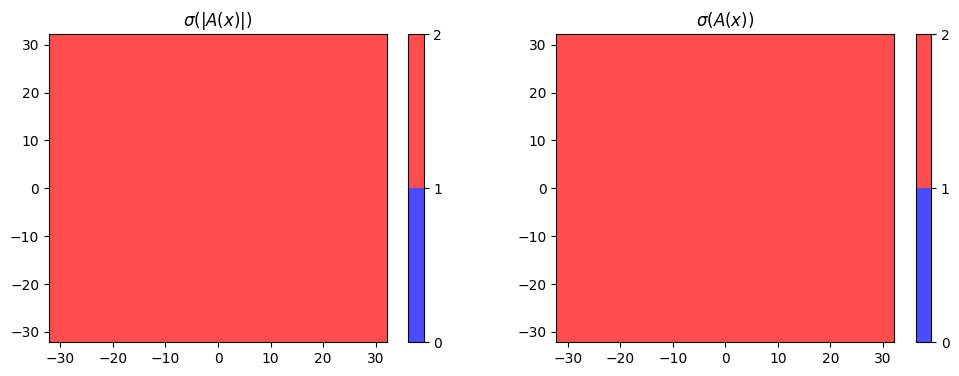

In [17]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

x = np.linspace(-32, 32, 200)
X, Y = np.meshgrid(x, x)

S = []
S_abs = []
for x, y in zip(X.flatten(), Y.flatten()):
    H = ackley_hessian(np.array([x,y]))
    sigma, sigma_abs = spectral_radii(H, alpha=1.8572, beta_1=0.9, epsilon=1e-5)
    S.append(sigma)
    S_abs.append(sigma_abs)

S = np.real(np.array(S).reshape(X.shape))
S_abs = np.array(S_abs).reshape(X.shape)

# Create the colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["blue", "red"])

# define the bins and normalize
bounds = [0,1,2]
norm = BoundaryNorm(bounds, cmap.N)

# Create a subplots figure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(121)
plt.pcolormesh(X, Y, S_abs, cmap=cmap, alpha=0.7, norm=norm)
plt.title(r"$\sigma(|A(x)|)$")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X, Y, S, cmap=cmap, alpha=0.7, norm=norm)
plt.title(r"$\sigma(A(x))$")
plt.colorbar()
plt.show()

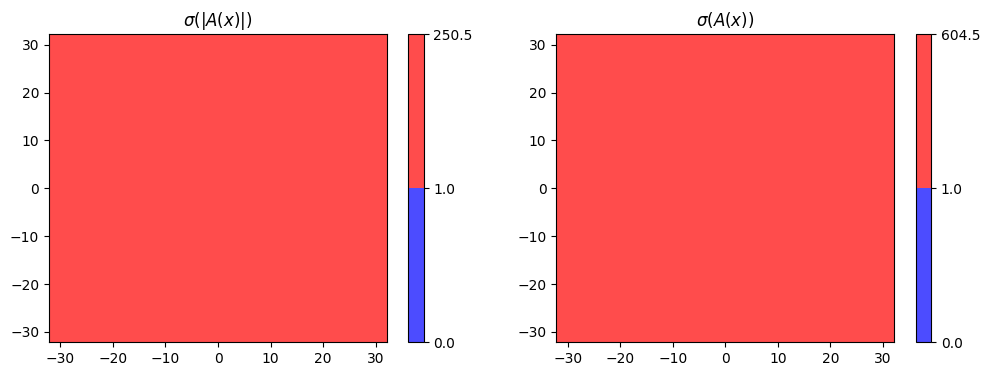

In [15]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

x = np.linspace(-32, 32, 200)
X, Y = np.meshgrid(x, x)

S = []
S_abs = []
for x, y in zip(X.flatten(), Y.flatten()):
    H = ackley_hessian(np.array([x,y]))
    sigma, sigma_abs = spectral_radii(H, alpha=0.3563, beta_1=0.9, epsilon=1e-5)
    S.append(sigma)
    S_abs.append(sigma_abs)

S = np.real(np.array(S).reshape(X.shape))
S_abs = np.array(S_abs).reshape(X.shape)

# Create the colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["blue", "red"])

# define the bins and normalize
bounds1 = [0,1,np.max(S)]
norm1 = BoundaryNorm(bounds1, cmap.N)

bounds2 = [0,1,np.max(S_abs)]
norm2 = BoundaryNorm(bounds2, cmap.N)

# Create a subplots figure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(121)
plt.pcolormesh(X, Y, S_abs, cmap=cmap, alpha=0.7, norm=norm1)
plt.title(r"$\sigma(|A(x)|)$")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X, Y, S, cmap=cmap, alpha=0.7, norm=norm2)
plt.title(r"$\sigma(A(x))$")
plt.colorbar()
plt.show()

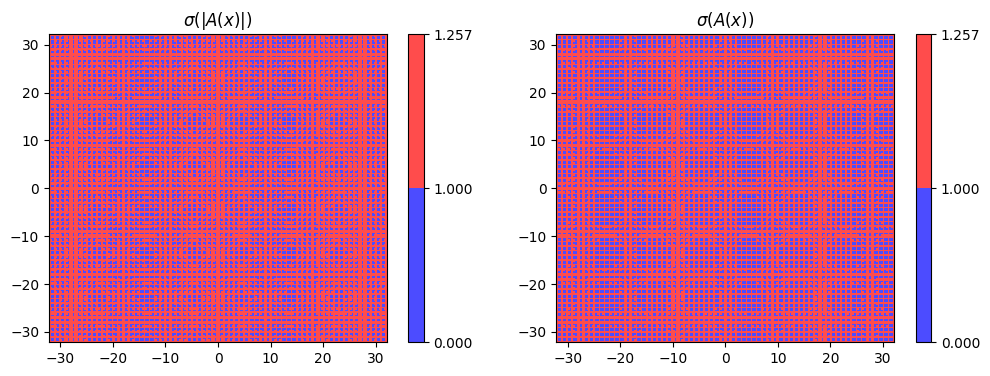

In [16]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

x = np.linspace(-32, 32, 200)
X, Y = np.meshgrid(x, x)

S = []
S_abs = []
for x, y in zip(X.flatten(), Y.flatten()):
    H = ackley_hessian(np.array([x,y]))
    sigma, sigma_abs = spectral_radii(H, alpha=1e-4, beta_1=0.9, epsilon=1e-5)
    S.append(sigma)
    S_abs.append(sigma_abs)

S = np.real(np.array(S).reshape(X.shape))
S_abs = np.array(S_abs).reshape(X.shape)

# Create the colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["blue", "red"])

# define the bins and normalize
bounds1 = [0,1,np.max(S)]
norm1 = BoundaryNorm(bounds1, cmap.N)

bounds2 = [0,1,np.max(S_abs)]
norm2 = BoundaryNorm(bounds2, cmap.N)

# Create a subplots figure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(121)
plt.pcolormesh(X, Y, S_abs, cmap=cmap, alpha=0.7, norm=norm1)
plt.title(r"$\sigma(|A(x)|)$")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X, Y, S, cmap=cmap, alpha=0.7, norm=norm2)
plt.title(r"$\sigma(A(x))$")
plt.colorbar()
plt.show()

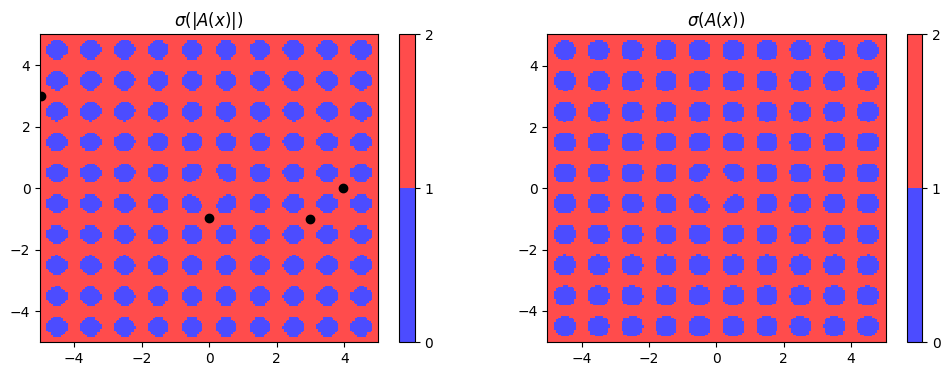

In [14]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

x = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, x)

S = []
S_abs = []
for x, y in zip(X.flatten(), Y.flatten()):
    H = ackley_hessian(np.array([x,y]))
    sigma, sigma_abs = spectral_radii(H, alpha=1e-4, beta_1=0.9, epsilon=1e-5)
    S.append(sigma)
    S_abs.append(sigma_abs)

S = np.real(np.array(S).reshape(X.shape))
S_abs = np.array(S_abs).reshape(X.shape)

# Create the colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["blue", "red"])

# define the bins and normalize
bounds = [0,1,2]
norm = BoundaryNorm(bounds, cmap.N)

# Create a subplots figure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Get local mins
local_mins = [get_local_min(ackley, ackley_deriv, domain=(-5,5)) for i in range(100)]

plt.subplot(121)
plt.scatter(*np.array(local_mins).T, c="k", zorder=10)
plt.pcolormesh(X, Y, S_abs, cmap=cmap, alpha=0.7, norm=norm)
plt.gca().set_xlim(-5, 5)
plt.gca().set_ylim(-5, 5)

plt.title(r"$\sigma(|A(x)|)$")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(X, Y, S, cmap=cmap, alpha=0.7, norm=norm)
plt.title(r"$\sigma(A(x))$")
plt.colorbar()
plt.show()